In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
import random
from sklearn.model_selection import train_test_split
from node2vec import Node2Vec
import lightgbm as lgbm

In [2]:
edges = pd.read_csv('Datasets/edges.csv', usecols = ["User_1", "User_2"])
nodes = pd.read_csv('Datasets/nodes.csv', usecols = ["User_ID", "User", "Country"])

In [3]:
edges.head()

User_1  User_2
0       6      44
1      49       6
2      15       4
3      61      67
4      31      17

In [4]:
nodes.head()

User_ID            User                   Country
0        1  Mark Hernandez  United States of America
1        2    Oliver Jones  United States of America
2        3     Niam Taylor  United States of America
3        4    Oliver Lopez  United States of America
4        5     Mary Miller  United States of America

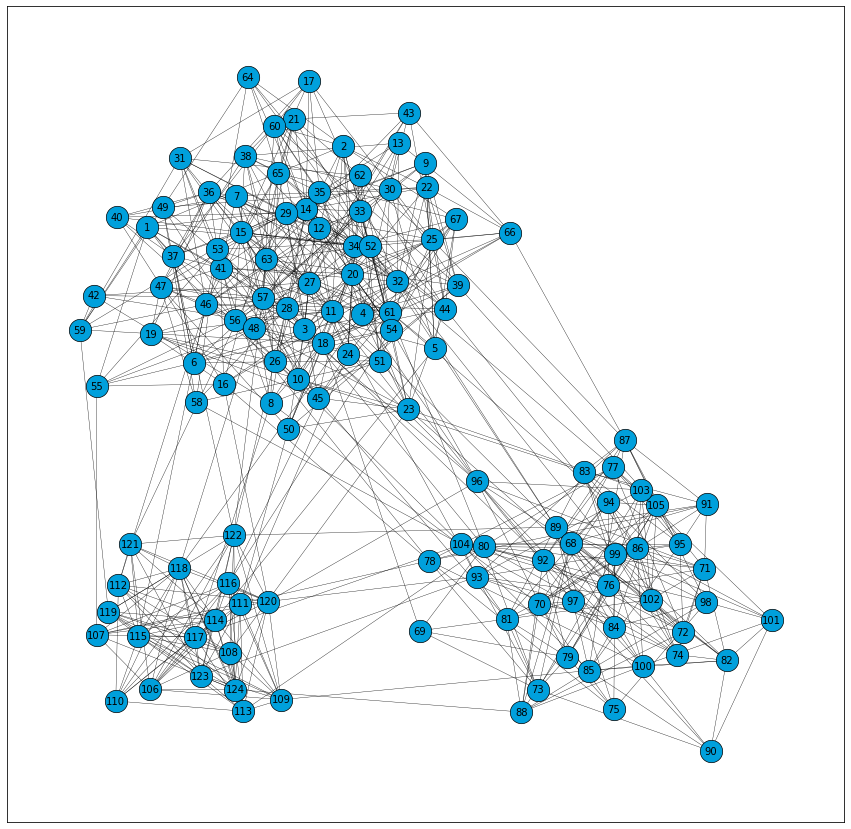

In [5]:
G = nx.from_pandas_edgelist(edges, "User_1", "User_2", create_using = nx.Graph())

options = {
    "font_size": 10,
    "node_size": 500,
    "node_color": "#00A0DC",
    "edgecolors": "black",
    "linewidths": 0.7,
    "width": 0.35,
}

plt.figure(figsize = (15, 15))
nx.draw_networkx(G, **options, pos = nx.spring_layout(G, seed=1111))
plt.show()

In [6]:
# all nodes in the graph
all_nodes = list(nodes["User_ID"])

# adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = all_nodes)

In [7]:
adj_G.shape

(124, 124)

In [8]:
# 1 means the corresponding nodes are connected with an edge
# 0 means the nodes are not connected directly
adj_G

matrix([[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 1.],
        [0., 0., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

In [9]:
separate_pairs = []

col = 1
for i in range(adj_G.shape[0]):
    for j in range(col, adj_G.shape[1]):
        if adj_G[i, j] == 0:
            separate_pairs.append([all_nodes[i], all_nodes[j]])
    col += 1
    

In [10]:
len(separate_pairs)

6957

In [11]:
df = pd.DataFrame({"User_1":[pair[0] for pair in separate_pairs],
                  "User_2":[pair[1] for pair in separate_pairs]})
df["connection"] = 0

df.head()

User_1  User_2  connection
0       1       3           0
1       1       4           0
2       1       5           0
3       1       6           0
4       1       7           0

In [12]:
# number of all nodes
nodes_num = len(G.nodes)

edges_copy = edges.copy()

#list to put removable connections
removable = []

for index in edges.index.values:
    
    # removing the pair of node and building another temporary graph
    G_new = nx.from_pandas_edgelist(edges_copy.drop(index = index), "User_1", "User_2", create_using = nx.Graph())
    
    # checking whether the graph became disconnected or not
    # also checking whether the number of nodes remainesd the same
    if nx.number_connected_components(G_new) == 1 and len(G_new.nodes) == nodes_num:
        removable.append(index)
        edges_copy.drop(index = index, inplace = True)


In [13]:
# number of connections that can be removed
len(removable)

661

In [14]:
# dataframe from removable connections
edge_removables = edges.loc[removable]

edge_removables["connection"] = 1

# joining nodes with no connection with nodes that can be removed
df = df.append(edge_removables[["User_1", "User_2", "connection"]], ignore_index = True)

/tmp/ipykernel_25480/2847428647.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(edge_removables[["User_1", "User_2", "connection"]], ignore_index = True)


In [15]:
df["connection"].value_counts()

0    6957
1     661
Name: connection, dtype: int64

We have imbalanced data

In [16]:
# dropping removable connections
edges_core = edges.drop(index = edge_removables.index.values)

# building new graph from core nodes
G_core = nx.from_pandas_edgelist(edges_core, "User_1", "User_2", create_using = nx.Graph())

In [17]:
node2vec = Node2Vec(G_core, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
model_n2v = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/124 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████| 50/50 [00:00<00:00, 135.47it/s]


In [18]:
# sum of features of connected edges
x = [(model_n2v.wv[str(i)]+model_n2v.wv[str(j)]) for i, j in zip(df['User_1'], df['User_2'])]

In [19]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x), df['connection'], 
                                                test_size = 0.3, 
                                                random_state = 25)

In [20]:
train_df = lgbm.Dataset(x_train, y_train)
test_df = lgbm.Dataset(x_test, y_test)

In [21]:
# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 25
}

model = lgbm.train(parameters,
                  train_set = train_df, 
                  num_boost_round = 1000,
                  valid_sets = test_df,
                  early_stopping_rounds = 50)

/home/mksash/Trash/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 482, number of negative: 4850
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 5332, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090398 -> initscore=-2.308790
[LightGBM] [Info] Start training from score -2.308790
[1]	valid_0's auc: 0.542809
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.54038
[3]	valid_0's auc: 0.537319
[4]	valid_0's auc: 0.537989
[5]	valid_0's auc: 0.546378
[6]	valid_0's auc: 0.554889
[7]	valid_0's auc: 0.563073
[8]	valid_0's auc: 0.565021
[9]	valid_0's auc: 0.565541
[10]	valid_0's auc: 0.570338
[11]	valid_0's auc: 0.575096
[12]	valid_0's auc: 0.57666
[13]	valid_0's auc: 0.574171
[14]	valid_0's auc: 0.571232
[15]	valid_0's auc: 0.571174
[16]	valid_0's auc: 

Our ROC_AUC score is not high enough because our data is small